In [15]:
import spacy
import textacy
from textacy import *
from textacy import preprocessing, extract

In [6]:
en = textacy.load_spacy_lang("en_core_web_sm")

In [8]:
text = open("nlphistory.txt","r").read()
text_cleaned = preprocessing.normalize.whitespace(text)
text_cleaned = preprocessing.remove.punctuation(text_cleaned)
text_cleaned = preprocessing.normalize.hyphenated_words(text_cleaned)

In [12]:
from textacy import extract
list(extract.keyword_in_context(text_cleaned, "language", window_width=25, pad_context=True))

[('  The history of natural ', 'language', ' processing generally sta'),
 ('tably successful natural ', 'language', ' processing systems devel'),
 ('s were SHRDLU  a natural ', 'language', ' system working in restri'),
 ('o the 1980s most natural ', 'language', ' processing systems were '),
 (' a revolution in natural ', 'language', ' processing with the intr'),
 (' learning algorithms for ', 'language', ' processing  This was due'),
 ('ine learning approach to ', 'language', ' processing  3  Some of t'),
 ('Markov models to natural ', 'language', ' processing  and increasi'),
 ('he input data  The cache ', 'language', ' models upon which many s'),
 ('edings into all official ', 'language', 's of the corresponding sy'),
 ('me widespread in natural ', 'language', ' processing  due in part '),
 (' results in many natural ', 'language', ' tasks  for example in la'),
 ('ge tasks  for example in ', 'language', ' modeling  6  parsing  7 '),
 ('from statistical natural ', 'language', ' proces

In [13]:
doc = textacy.make_spacy_doc(text, lang="en_core_web_sm")
doc._.preview


'Doc(1090 tokens: "The history of natural language processing gene...")'

In [14]:
from textacy import text_stats as ts
ts.basics.n_words(doc)

904

In [25]:
print([chunk for chunk in textacy.extract.noun_chunks(doc)])

[history, natural language processing, 1950s, work, earlier periods, Alan Turing, article, "Intelligence, which, what, Turing test, criterion, intelligence, Georgetown experiment, fully automatic translation, more than sixty Russian sentences, English, authors, three or five years, machine translation, real progress, ALPAC report, which, ten-year-long research, expectations, funding, machine translation, Little further research, machine translation, late 1980s, first statistical machine translation systems, notably successful natural language processing systems, 1960s, natural language system, restricted "blocks worlds, restricted vocabularies, ELIZA, simulation, Rogerian psychotherapist, Joseph Weizenbaum, almost no information, human thought, emotion, ELIZA, startlingly human-like interaction, "patient, very small knowledge base, generic response, example, My head, you, your head, 1970s, many programmers, "conceptual ontologies, which, real-world information, computer-understandable 

In [27]:
extract.keyterms.textrank(doc, topn=5)

[('successful natural language processing system', 0.024625341403960145),
 ('statistical machine translation system', 0.024508421175294396),
 ('natural language system', 0.020414310118706182),
 ('statistical natural language processing', 0.0184803120836678),
 ('natural language task', 0.015718423539873877)]

# NER

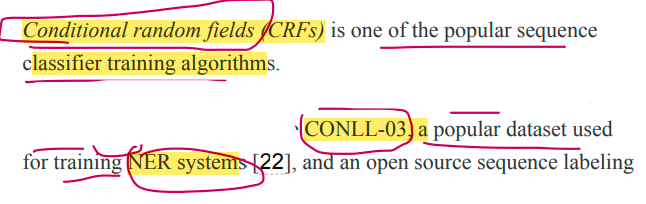
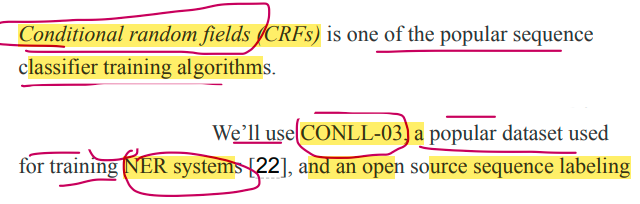
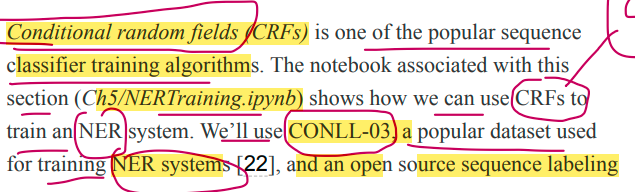

In [7]:
from nltk.tag import pos_tag
from sklearn_crfsuite import CRF, metrics
from sklearn.metrics import make_scorer,confusion_matrix
from pprint import pprint
from sklearn.metrics import f1_score,classification_report
from sklearn.pipeline import Pipeline
import string
import warnings
warnings.filterwarnings('ignore')

<span style="color:yellow">conll data</span>

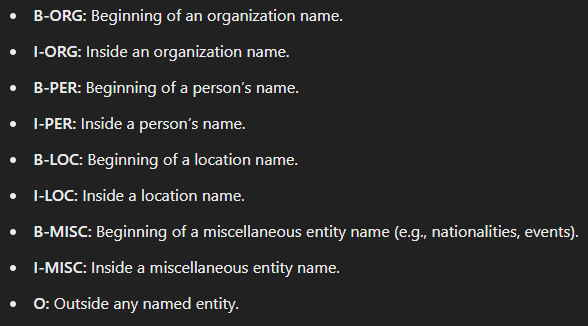

In [8]:
def load__data_conll(file_path):
    myoutput,words,tags = [],[],[]
    fh = open(file_path)
    for line in fh:
        line = line.strip()
        if "\t" not in line:
            myoutput.append([words,tags])
            words,tags = [],[]
        else:
            word, tag = line.split("\t")
            words.append(word)
            tags.append(tag)
    fh.close()
    return myoutput

In [9]:
def sent2feats(sentence):
    feats = []
    sen_tags = pos_tag(sentence) #This format is specific to this POS tagger!
    for i in range(0,len(sentence)):
        word = sentence[i]
        wordfeats = {}
       #word features: word, prev 2 words, next 2 words in the sentence.
        wordfeats['word'] = word
        if i == 0:
            wordfeats["prevWord"] = wordfeats["prevSecondWord"] = "<S>"
        elif i==1:
            wordfeats["prevWord"] = sentence[0]
            wordfeats["prevSecondWord"] = "</S>"
        else:
            wordfeats["prevWord"] = sentence[i-1]
            wordfeats["prevSecondWord"] = sentence[i-2]
        #next two words as features
        if i == len(sentence)-2:
            wordfeats["nextWord"] = sentence[i+1]
            wordfeats["nextNextWord"] = "</S>"
        elif i==len(sentence)-1:
            wordfeats["nextWord"] = "</S>"
            wordfeats["nextNextWord"] = "</S>"
        else:
            wordfeats["nextWord"] = sentence[i+1]
            wordfeats["nextNextWord"] = sentence[i+2]
        
        #POS tag features: current tag, previous and next 2 tags.
        wordfeats['tag'] = sen_tags[i][1]
        if i == 0:
            wordfeats["prevTag"] = wordfeats["prevSecondTag"] = "<S>"
        elif i == 1:
            wordfeats["prevTag"] = sen_tags[0][1]
            wordfeats["prevSecondTag"] = "</S>"
        else:
            wordfeats["prevTag"] = sen_tags[i - 1][1]

            wordfeats["prevSecondTag"] = sen_tags[i - 2][1]
            # next two words as features
        if i == len(sentence) - 2:
            wordfeats["nextTag"] = sen_tags[i + 1][1]
            wordfeats["nextNextTag"] = "</S>"
        elif i == len(sentence) - 1:
            wordfeats["nextTag"] = "</S>"
            wordfeats["nextNextTag"] = "</S>"
        else:
            wordfeats["nextTag"] = sen_tags[i + 1][1]
            wordfeats["nextNextTag"] = sen_tags[i + 2][1]
        #That is it! You can add whatever you want!
        feats.append(wordfeats)
    return feats

In [33]:
pos_tag("hello ram how are you".split(" "))

[('hello', 'NN'),
 ('ram', 'VB'),
 ('how', 'WRB'),
 ('are', 'VBP'),
 ('you', 'PRP')]

In [32]:
sent2feats("hello ram how are you".split(" "))

[{'word': 'hello',
  'prevWord': '<S>',
  'prevSecondWord': '<S>',
  'nextWord': 'ram',
  'nextNextWord': 'how',
  'tag': 'NN',
  'prevTag': '<S>',
  'prevSecondTag': '<S>',
  'nextTag': 'VB',
  'nextNextTag': 'WRB'},
 {'word': 'ram',
  'prevWord': 'hello',
  'prevSecondWord': '</S>',
  'nextWord': 'how',
  'nextNextWord': 'are',
  'tag': 'VB',
  'prevTag': 'NN',
  'prevSecondTag': '</S>',
  'nextTag': 'WRB',
  'nextNextTag': 'VBP'},
 {'word': 'how',
  'prevWord': 'ram',
  'prevSecondWord': 'hello',
  'nextWord': 'are',
  'nextNextWord': 'you',
  'tag': 'WRB',
  'prevTag': 'VB',
  'prevSecondTag': 'NN',
  'nextTag': 'VBP',
  'nextNextTag': 'PRP'},
 {'word': 'are',
  'prevWord': 'how',
  'prevSecondWord': 'ram',
  'nextWord': 'you',
  'nextNextWord': '</S>',
  'tag': 'VBP',
  'prevTag': 'WRB',
  'prevSecondTag': 'VB',
  'nextTag': 'PRP',
  'nextNextTag': '</S>'},
 {'word': 'you',
  'prevWord': 'are',
  'prevSecondWord': 'how',
  'nextWord': '</S>',
  'nextNextWord': '</S>',
  'tag': 'PR

In [10]:
def get_feats_conll(conll_data):
    feats = []
    labels = []
    for sentence in conll_data:
        feats.append(sent2feats(sentence[0]))
        labels.append(sentence[1])
    return feats, labels

In [15]:
def print_cm(cm, labels):
    print("\n")
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        sum = 0
        for j in range(len(labels)):
            cell = "%{0}.0f".format(columnwidth) % cm[i, j]
            sum =  sum + int(cell)
            print(cell, end=" ")
        print(sum) #Prints the total number of instances per cat at the end.

In [36]:
def get_confusion_matrix(y_true,y_pred,labels):
    trues,preds = [], []
    for yseq_true, yseq_pred in zip(y_true, y_pred):
        trues.extend(yseq_true)
        preds.extend(yseq_pred)
    print_cm(confusion_matrix(trues,preds),labels)

In [44]:

train_path = 'conlldata/train.txt'
test_path = 'conlldata/test.txt'
    
conll_train = load__data_conll(train_path)
conll_dev = load__data_conll(test_path)

print("Training a Sequence classification model with CRF")
X_train, Y_train = get_feats_conll(conll_train)
X_dev, Y_dev = get_feats_conll(conll_dev)


crf = CRF(algorithm='lbfgs', c1=0.1, c2=10, max_iterations=50)

crf.fit(X_train, Y_train)
labels = list(crf.classes_)

y_pred = crf.predict(X_dev)
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
print(metrics.flat_f1_score(Y_dev, y_pred,average='weighted', labels=labels))
print(metrics.flat_classification_report(Y_dev, y_pred, labels=sorted_labels, digits=3))

get_confusion_matrix(Y_dev, y_pred,labels=sorted_labels)
print("Done with sequence model")


Training a Sequence classification model with CRF
0.9255103670420659
              precision    recall  f1-score   support

           O      0.973     0.981     0.977     38323
       B-LOC      0.694     0.765     0.728      1668
       I-LOC      0.738     0.482     0.584       257
      B-MISC      0.648     0.309     0.419       702
      I-MISC      0.626     0.505     0.559       216
       B-ORG      0.670     0.561     0.611      1661
       I-ORG      0.551     0.704     0.618       835
       B-PER      0.773     0.766     0.769      1617
       I-PER      0.819     0.886     0.851      1156

    accuracy                          0.928     46435
   macro avg      0.721     0.662     0.679     46435
weighted avg      0.926     0.928     0.926     46435



                O  B-LOC  I-LOC B-MISC I-MISC  B-ORG  I-ORG  B-PER  I-PER 
         O   1276     36     95     98      1      1     14      4    143 1668
     B-LOC     48    217     56     19      1      2     13      2    

In [62]:
def NERpipeline(sentence):
    sentence = sent2feats(sentence.split(" "))
    return crf.predict([sentence])

In [75]:
NERpipeline("Nadim Ladki is from EU")

array([['B-PER', 'I-PER', 'O', 'O', 'B-LOC']], dtype=object)

similairly spacy model can be trained for NER for custom dataset

In [77]:
! python -m spacy download en_core_web_lg

     -------------------------------------- 587.7/587.7 MB 1.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [78]:
import spacy
nlp = spacy.load("en_core_web_lg")
text_from_fig = "On Tuesday, Apple announced its plans for another major chunk  of the money: It will buy back a further $75 billion in stock."
doc = nlp(text_from_fig)


In [79]:
for ent in doc.ents:
    if ent.text:
        print(ent.text, "\t", ent.label_)

Tuesday 	 DATE
Apple 	 ORG
$75 billion 	 MONEY


# <span style="color:yellow"> NAME ENTITY LINKING {NEL}</span>

In [81]:
# !pip install spacy-lookups-data


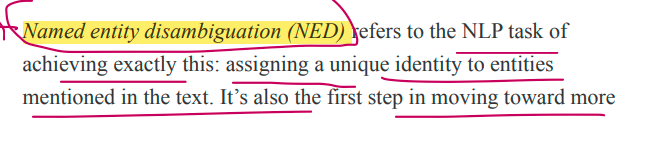
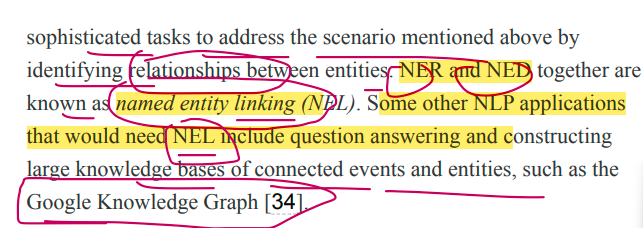

In [129]:
import spacy
from spacy.language import Language
from spacy.tokens import Span

# Load spaCy model
nlp = spacy.load("en_core_web_sm")


kb = {
    "Barack Obama": {
        "id": "Q76",
        "description": "44th President of the United States"
    },
    "Hawaii": {
        "id": "Q782",
        "description": "U.S. state"
    },
    "john": {
        "id": "Q783",
        "description": "U.S. marine"
    },
    "peru": {
        "id": "Q7842",
        "description": "Latin nation"
    },
    "Hawaii": {
        "id": "Q5782",
        "description": "U.S. state"
    },
    "Amazon": {
        "id": "Q6782",
        "description": "Rain forest"
    },
    "centepede": {
        "id": "Q7842",
        "description": "freaky creature"
    },
    "Martin Garixx": {
        "id": "Q73282",
        "description": "D.J"
    },
}

@Language.component("custom_entity_linker")
def custom_entity_linker(doc):
    for ent in doc.ents:
        if ent.text in kb:
            ent._.kb_id = kb[ent.text]["id"]
            ent._.description = kb[ent.text]["description"]
    return doc

if not Span.has_extension("kb_id"):
    Span.set_extension("kb_id", default=None)
if not Span.has_extension("description"):
    Span.set_extension("description", default=None)

try:
    if "custom_entity_linker" not in nlp.pipe_names:
        nlp.add_pipe("custom_entity_linker", last=True)
except ValueError as e:
    print(f"Error adding pipeline component: {e}")
    # If you want to force replace an existing component, you can use:
    # nlp.replace_pipe("custom_entity_linker", "custom_entity_linker")

In [130]:

# Test the NEL
text = "Barack Obama was enjoying the party in peru near Amazon where friend Martin Garixx was the invited also"
doc = nlp(text)

# Print the results
for ent in doc.ents:
    print(f"Entity: {ent.text}")
    print(f"Label: {ent.label_}")
    print(f"KB ID: {ent._.kb_id}")
    print(f"Description: {ent._.description}")
    print()

Entity: Barack Obama
Label: PERSON
KB ID: Q76
Description: 44th President of the United States

Entity: peru
Label: GPE
KB ID: Q7842
Description: Latin nation

Entity: Amazon
Label: GPE
KB ID: Q6782
Description: Rain forest

Entity: Martin Garixx
Label: PERSON
KB ID: Q73282
Description: D.J



In [132]:
import spacy
from spacy.language import Language
from spacy.tokens import Span
import difflib

nlp = spacy.load("en_core_web_sm")

kb = {
    "Barack Obama": {
        "id": "Q76",
        "description": "44th President of the United States",
        "aliases": ["Obama", "President Obama", "Barry"]
    },
    "Michelle Obama": {
        "id": "Q13133",
        "description": "Former First Lady of the United States",
        "aliases": ["Michelle Robinson", "Mrs. Obama"]
    },
    "Hawaii": {
        "id": "Q782",
        "description": "U.S. state",
        "aliases": ["Aloha State", "Hawaiian Islands"]
    },
    "Illinois": {
        "id": "Q1204",
        "description": "U.S. state",
        "aliases": ["Land of Lincoln", "Prairie State"]
    }
}

In [133]:

def find_best_match(entity_text, kb):
    best_match = None
    highest_ratio = 0
    for key in kb:
        ratio = difflib.SequenceMatcher(None, entity_text.lower(), key.lower()).ratio()
        if ratio > highest_ratio:
            highest_ratio = ratio
            best_match = key
        for alias in kb[key]["aliases"]:
            alias_ratio = difflib.SequenceMatcher(None, entity_text.lower(), alias.lower()).ratio()
            if alias_ratio > highest_ratio:
                highest_ratio = alias_ratio
                best_match = key
    return best_match if highest_ratio > 0.8 else None

In [134]:

@Language.component("advanced_entity_linker")
def advanced_entity_linker(doc):
    for ent in doc.ents:
        best_match = find_best_match(ent.text, kb)
        if best_match:
            ent._.kb_id = kb[best_match]["id"]
            ent._.description = kb[best_match]["description"]
            ent._.confidence = difflib.SequenceMatcher(None, ent.text.lower(), best_match.lower()).ratio()
        else:
            ent._.kb_id = None
            ent._.description = None
            ent._.confidence = 0.0
    return doc

In [135]:
if not Span.has_extension("kb_id"):
    Span.set_extension("kb_id", default=None)
if not Span.has_extension("description"):
    Span.set_extension("description", default=None)
if not Span.has_extension("confidence"):
    Span.set_extension("confidence", default=None)

if "advanced_entity_linker" not in nlp.pipe_names:
    nlp.add_pipe("advanced_entity_linker", last=True)


In [136]:
texts = [
    "Barack Obama was born in Hawaii but he was a senator from Illinois.",
    "The former president, often called Barry by his friends, visited his home state.",
    "Michelle Obama, born Michelle Robinson, is from Chicago, Illinois.",
    "The Aloha State is known for its beautiful beaches.",
]

for text in texts:
    doc = nlp(text)
    print(f"Text: {text}")
    for ent in doc.ents:
        print(f"Entity: {ent.text}")
        print(f"Type: {ent.label_}")
        print(f"KB ID: {ent._.kb_id}")
        print(f"Description: {ent._.description}")
        print(f"Confidence: {ent._.confidence:.2f}")
        print()
    print("---")

Text: Barack Obama was born in Hawaii but he was a senator from Illinois.
Entity: Barack Obama
Type: PERSON
KB ID: Q76
Description: 44th President of the United States
Confidence: 1.00

Entity: Hawaii
Type: GPE
KB ID: Q782
Description: U.S. state
Confidence: 1.00

Entity: Illinois
Type: GPE
KB ID: Q1204
Description: U.S. state
Confidence: 1.00

---
Text: The former president, often called Barry by his friends, visited his home state.
Entity: Barry
Type: PERSON
KB ID: Q76
Description: 44th President of the United States
Confidence: 0.35

---
Text: Michelle Obama, born Michelle Robinson, is from Chicago, Illinois.
Entity: Michelle Obama
Type: PERSON
KB ID: Q13133
Description: Former First Lady of the United States
Confidence: 1.00

Entity: Michelle Robinson
Type: PERSON
KB ID: Q13133
Description: Former First Lady of the United States
Confidence: 0.71

Entity: Chicago
Type: GPE
KB ID: None
Description: None
Confidence: 0.00

Entity: Illinois
Type: GPE
KB ID: Q1204
Description: U.S. state

In [149]:
difflib.SequenceMatcher(None, "i eat the fruit".lower(),"i like and i eat the fruit".lower()).ratio()

0.7317073170731707